In [10]:
import psycopg2

import numpy as np
import pandas as pd
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

from pprint import pprint
from collections import OrderedDict

from clickhouse_driver import Client

client = Client('localhost', database="spoofdb")

In [2]:
%%time 

exp_data_sql = """
SELECT
	ex.*
FROM
	experiment ex
"""
exp_df = client.query_dataframe(exp_data_sql)
print("\n".join(exp_df.exp_id.unique().tolist()))
print()
exp_df

TEST_gigabit_attack_without_spoof
TEST_gigabit_attack_with_spoof

CPU times: user 18.2 ms, sys: 1.77 ms, total: 19.9 ms
Wall time: 30.9 ms


,exp_id,attacker_rate,server_connections,max_keep_alive_requests,num_clients,num_trials,origin_server_duration,attacker_duration,receiver_duration,proxy_duration,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,TEST_gigabit_attack_without_spoof,1000mbps,256,0,1,1,120,20,120,120,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,False,True
1,TEST_gigabit_attack_with_spoof,1000mbps,256,0,1,1,120,20,120,120,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,False,True


In [3]:
%%time 

fetch_metadata_sql = """
SELECT
	n.node_name,
	dn.dnid,
	dn.node_id,
  dn.exp_id
FROM 
	deployed_node dn
	JOIN node n ON n.node_id = dn.node_id
"""

metadata_df = client.query_dataframe(fetch_metadata_sql)

dnid_map_node_name = dict()
dnid_map_exp_id = dict()
node_id_map_node_name = dict()

for record in metadata_df.to_dict(orient="records"):
  dnid = record["dnid"]
  node_id = record["node_id"]
  node_name = record["node_name"]
  exp_id = record["exp_id"]
  
  assert dnid not in dnid_map_node_name
  dnid_map_node_name[dnid] = node_name
  dnid_map_exp_id[dnid] = exp_id
  
  if node_id in node_id_map_node_name:
    assert node_id_map_node_name[node_id] == node_name
  else:
    node_id_map_node_name[node_id] = node_name
  
client_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("client"))
attacker_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("attacker"))

client_node_ids = set(node_id for node_id, node_name in node_id_map_node_name.items() if node_name.startswith("client"))

print(f"{client_dnids=}")
print(f"{attacker_dnids=}")
print(f"{client_node_ids=}")

client_dnids={2, 7}
attacker_dnids={1, 6}
client_node_ids={2}
CPU times: user 6.28 ms, sys: 0 ns, total: 6.28 ms
Wall time: 13.8 ms


In [9]:
%%time

inter_node_messages_sql = f"""
SELECT
  dn.exp_id AS exp_id,
  e.trial AS trial,
  e.observe_timestamp AS observe_timestamp,
  m.src_id AS src_id,
  m.dst_id AS dst_id,
  m.size_bytes AS size_bytes
FROM
  event e
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  JOIN message m ON m.message_id = e.message_id
"""

inter_node_messages_df = client.query_dataframe(inter_node_messages_sql)

inter_node_messages_df.replace({
  "src_id": node_id_map_node_name,
  "dst_id": node_id_map_node_name,
}, inplace=True)

# Establish src->dst communication patterns
inter_node_messages_df["communication_pattern"] = inter_node_messages_df["src_id"].astype(str) + "->" + inter_node_messages_df["dst_id"].astype(str)
inter_node_messages_df.drop(columns=["src_id", "dst_id"], inplace=True)

# Define bins of timestamps
bins = np.ceil(inter_node_messages_df["observe_timestamp"].max())
inter_node_messages_df["timestamp_bin"] = np.floor(inter_node_messages_df["observe_timestamp"])

# Group messages into timestamp bins
binned_messages_df = (
  inter_node_messages_df
  .groupby(by=["exp_id", "trial", "communication_pattern", "timestamp_bin"])
  .agg(sum_bytes=('size_bytes', 'sum'))
  .reset_index()
)

# Derive sending rates from the timestamp-binned messages
binned_messages_df.sort_values(by="timestamp_bin", inplace=True)
binned_messages_df["megabytes_per_second"] = 1e-6 * binned_messages_df["sum_bytes"]
binned_messages_df["megabits_per_second"] = 8 * binned_messages_df["megabytes_per_second"]

inter_node_messages_df
binned_messages_df

CPU times: user 9.94 s, sys: 3.62 s, total: 13.6 s
Wall time: 13.7 s


,exp_id,trial,communication_pattern,timestamp_bin,sum_bytes,megabytes_per_second,megabits_per_second
0,TEST_gigabit_attack_with_spoof,1,client1->proxy,0.0,3132,0.003132,0.025056
520,TEST_gigabit_attack_without_spoof,1,originserver->proxy,0.0,14784,0.014784,0.118272
646,TEST_gigabit_attack_without_spoof,1,proxy->client1,0.0,4898,0.004898,0.039184
268,TEST_gigabit_attack_with_spoof,1,proxy->originserver,0.0,6012,0.006012,0.048096
436,TEST_gigabit_attack_without_spoof,1,client1->proxy,0.0,3342,0.003342,0.026736
...,...,...,...,...,...,...,...
185,TEST_gigabit_attack_with_spoof,1,originserver->proxy,99.0,7392,0.007392,0.059136
267,TEST_gigabit_attack_with_spoof,1,proxy->client1,99.0,1264,0.001264,0.010112
367,TEST_gigabit_attack_with_spoof,1,proxy->originserver,99.0,3248,0.003248,0.025984
519,TEST_gigabit_attack_without_spoof,1,client1->proxy,99.0,1070,0.001070,0.008560


CPU times: user 872 ms, sys: 160 ms, total: 1.03 s
Wall time: 694 ms


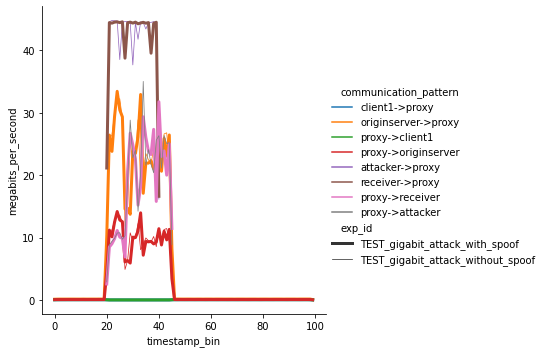

In [13]:
%%time

g = sns.relplot(
  data=binned_messages_df,
  kind="line",
  x="timestamp_bin",
  y="megabits_per_second",
  hue="communication_pattern",
  size="exp_id",
)

In [27]:
%%time

client_messages_sql = f"""
WITH client_sends AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
), 

client_recvs AS (
  SELECT
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_code AS response_code
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT
  client_sends.exp_id AS exp_id,
  client_sends.trial AS trial,
  client_sends.observer_id AS observer_id,
  client_sends.message_marker AS message_marker,
  groupArray(client_recvs.response_code)[1] AS response_code,
  MIN(client_sends.observe_timestamp) AS send_time_sec,
  MIN(client_recvs.observe_timestamp) AS recv_time_sec,
  MIN(client_sends.observe_timestamp) AS first_send_time_sec,
  MAX(client_sends.observe_timestamp) AS last_send_time_sec,
  MIN(client_recvs.observe_timestamp) AS first_recv_time_sec,
  MAX(client_recvs.observe_timestamp) AS last_recv_time_sec,
  1e3 * (MIN(client_recvs.observe_timestamp) - MIN(client_sends.observe_timestamp)) AS rtt_ms_first_transmission,
  1e3 * (MIN(client_recvs.observe_timestamp) - MAX(client_sends.observe_timestamp)) AS rtt_ms_last_transmission,
  COUNT(client_sends.observe_timestamp) AS num_send_observations,
  COUNT(client_recvs.observe_timestamp) AS num_recv_observations,
  SUM(CASE WHEN client_sends.coap_retransmitted = true THEN 1 ELSE 0 END) AS num_retransmissions
FROM client_sends
  JOIN client_recvs USING (trial, observer_id, message_marker)
GROUP BY 
  exp_id, trial, observer_id, message_marker
ORDER BY
  exp_id, trial, observer_id, message_marker
"""

message_rtt_df = client.query_dataframe(client_messages_sql)
message_rtt_df.observer_id.replace(dnid_map_node_name, inplace=True)

message_rtt_df["successful_message"] = False
message_rtt_df.loc[(message_rtt_df["response_code"] == "content"), "successful_message"] = True

print(message_rtt_df["response_code"].unique())

message_rtt_df

['content' 'bad_gateway']
CPU times: user 39.6 ms, sys: 1.27 ms, total: 40.9 ms
Wall time: 154 ms


,exp_id,trial,observer_id,message_marker,response_code,send_time_sec,recv_time_sec,first_send_time_sec,last_send_time_sec,first_recv_time_sec,last_recv_time_sec,rtt_ms_first_transmission,rtt_ms_last_transmission,num_send_observations,num_recv_observations,num_retransmissions,successful_message
0,TEST_gigabit_attack_with_spoof,1,client1,1,content,0.000000,0.204696,0.000000,0.000000,0.204696,0.204696,204.695940,204.695940,1,1,0,True
1,TEST_gigabit_attack_with_spoof,1,client1,2,content,0.222177,0.279323,0.222177,0.222177,0.279323,0.279323,57.146072,57.146072,1,1,0,True
2,TEST_gigabit_attack_with_spoof,1,client1,3,content,0.281784,0.338199,0.281784,0.281784,0.338199,0.338199,56.414843,56.414843,1,1,0,True
3,TEST_gigabit_attack_with_spoof,1,client1,4,content,0.340422,0.396020,0.340422,0.340422,0.396020,0.396020,55.598021,55.598021,1,1,0,True
4,TEST_gigabit_attack_with_spoof,1,client1,5,content,0.398487,0.453733,0.398487,0.398487,0.453733,0.453733,55.245876,55.245876,1,1,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2748,TEST_gigabit_attack_without_spoof,1,client1,515637,content,98.426995,98.479517,98.426995,98.426995,98.479517,98.479517,52.521944,52.521944,1,1,0,True
2749,TEST_gigabit_attack_without_spoof,1,client1,515638,content,98.480178,98.532624,98.480178,98.480178,98.532624,98.532624,52.446127,52.446127,1,1,0,True
2750,TEST_gigabit_attack_without_spoof,1,client1,515639,content,98.533295,98.585743,98.533295,98.533295,98.585743,98.585743,52.448034,52.448034,1,1,0,True
2751,TEST_gigabit_attack_without_spoof,1,client1,515640,content,98.586393,98.638940,98.586393,98.586393,98.638940,98.638940,52.546978,52.546978,1,1,0,True


In [28]:
%%time

metric_usage_sql = f"""
SELECT
	dn.exp_id,
	nm.trial,
	nm.observer_id,
	nm.metric_type,
	AVG(nm.metric_value) AS avg_value,
	MIN(nm.metric_value) AS min_value,
	MAX(nm.metric_value) AS max_value
FROM
	node_metric nm
	JOIN deployed_node dn ON dn.dnid = nm.observer_id
GROUP BY
	dn.exp_id, nm.trial, nm.observer_id, nm.metric_type
ORDER BY
	dn.exp_id, nm.trial, nm.metric_type, nm.observer_id
"""

metric_df = client.query_dataframe(metric_usage_sql)

metric_df

CPU times: user 4.33 ms, sys: 3.97 ms, total: 8.29 ms
Wall time: 18.5 ms


,exp_id,trial,observer_id,metric_type,avg_value,min_value,max_value
0,TEST_gigabit_attack_with_spoof,1,3,cpu_utilization,3.412500,0.4,20.3
1,TEST_gigabit_attack_with_spoof,1,4,cpu_utilization,12.972500,0.5,92.8
2,TEST_gigabit_attack_with_spoof,1,3,memory_utilization,249.890173,239.0,268.0
3,TEST_gigabit_attack_with_spoof,1,4,memory_utilization,3259.597276,240.0,4694.0
4,TEST_gigabit_attack_without_spoof,1,8,cpu_utilization,3.450000,0.4,20.2
5,TEST_gigabit_attack_without_spoof,1,9,cpu_utilization,12.408333,0.4,89.4
6,TEST_gigabit_attack_without_spoof,1,8,memory_utilization,252.497110,235.0,276.0
7,TEST_gigabit_attack_without_spoof,1,9,memory_utilization,3400.035019,241.0,4900.0


In [29]:
%%time

client_rps_df = (
  message_rtt_df
  .groupby(by=["exp_id", "trial", "observer_id"])
  .aggregate(
    num_messages=("successful_message", "count"),
    num_successful_messages=("successful_message", "sum"),
    num_retransmissions=("num_retransmissions", "sum"),
    stddev_rtt_ms=("rtt_ms_first_transmission", "std"),
    min_rtt_ms=("rtt_ms_first_transmission", "min"),
    median_rtt_ms=("rtt_ms_first_transmission", "median"),
    max_rtt_ms=("rtt_ms_first_transmission", "max"),
    rtt_ms_p0=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.00)),
    rtt_ms_p25=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.25)),
    rtt_ms_p50=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.50)),
    rtt_ms_p75=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.75)),
    rtt_ms_p99=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.99)),
    rtt_ms_p100=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=1.00)),
    first_active_time=("first_send_time_sec", "min"),
    last_active_time=("last_recv_time_sec", "max"),
  )
  .reset_index()
)
assert client_rps_df["min_rtt_ms"].eq(client_rps_df["rtt_ms_p0"]).all()
assert client_rps_df["median_rtt_ms"].eq(client_rps_df["rtt_ms_p50"]).all()
assert client_rps_df["max_rtt_ms"].eq(client_rps_df["rtt_ms_p100"]).all()

client_rps_df["num_failed_messages"] = client_rps_df["num_messages"] - client_rps_df["num_successful_messages"]
client_rps_df["average_rps"] = client_rps_df["num_successful_messages"] / (client_rps_df["last_active_time"] - client_rps_df["first_active_time"])

client_rps_df = client_rps_df.merge(exp_df, on="exp_id")
bool_col_replacement = {
  "run_proxy_with_dtls": {True: "dtls", False: "coap"},
  "run_proxy_with_https": {True: "https", False: "http"},
  "reuse_connections": {True: "reuse-connections", False: "no-connection-reuse"},
  "run_attacker": {True: "attacker", False: "no-attacker"},
}
client_rps_df.replace(bool_col_replacement, inplace=True)

client_rps_df

CPU times: user 75.5 ms, sys: 2.04 ms, total: 77.5 ms
Wall time: 81.7 ms


,exp_id,trial,observer_id,num_messages,num_successful_messages,num_retransmissions,stddev_rtt_ms,min_rtt_ms,median_rtt_ms,max_rtt_ms,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,TEST_gigabit_attack_with_spoof,1,client1,1377,1374,4,292.933861,51.935911,52.563906,5980.248928,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,reuse-connections,coap,http,attacker
1,TEST_gigabit_attack_without_spoof,1,client1,1376,1373,4,325.263600,52.112103,52.565575,7861.943960,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,reuse-connections,coap,http,attacker


In [30]:
message_rtt_df = message_rtt_df.merge(exp_df, on="exp_id")
message_rtt_df

,exp_id,trial,observer_id,message_marker,response_code,send_time_sec,recv_time_sec,first_send_time_sec,last_send_time_sec,first_recv_time_sec,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,TEST_gigabit_attack_with_spoof,1,client1,1,content,0.000000,0.204696,0.000000,0.000000,0.204696,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,False,True
1,TEST_gigabit_attack_with_spoof,1,client1,2,content,0.222177,0.279323,0.222177,0.222177,0.279323,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,False,True
2,TEST_gigabit_attack_with_spoof,1,client1,3,content,0.281784,0.338199,0.281784,0.281784,0.338199,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,False,True
3,TEST_gigabit_attack_with_spoof,1,client1,4,content,0.340422,0.396020,0.340422,0.340422,0.396020,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,False,True
4,TEST_gigabit_attack_with_spoof,1,client1,5,content,0.398487,0.453733,0.398487,0.398487,0.453733,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2748,TEST_gigabit_attack_without_spoof,1,client1,515637,content,98.426995,98.479517,98.426995,98.426995,98.479517,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,False,True
2749,TEST_gigabit_attack_without_spoof,1,client1,515638,content,98.480178,98.532624,98.480178,98.480178,98.532624,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,False,True
2750,TEST_gigabit_attack_without_spoof,1,client1,515639,content,98.533295,98.585743,98.533295,98.533295,98.585743,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,False,True
2751,TEST_gigabit_attack_without_spoof,1,client1,515640,content,98.586393,98.638940,98.586393,98.586393,98.638940,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,False,True


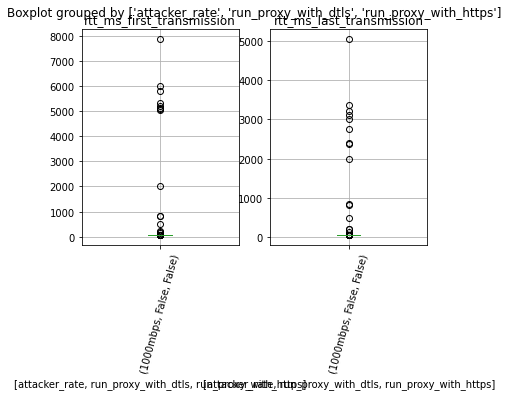

,,,average_rps
attacker_rate,run_proxy_with_dtls,run_proxy_with_https,
1000mbps,False,False,70.780087


In [33]:
df = message_rtt_df
param_comparison_scope = ["attacker_rate", "run_proxy_with_dtls", "run_proxy_with_https"]

plot_args = {
  "rot": 75,
  "by": param_comparison_scope,
}

plots = ["rtt_ms_first_transmission", "rtt_ms_last_transmission"]
_, axes = plt.subplots(1, len(plots))
for i, p in enumerate(plots):
  df.boxplot(p, ax=axes[i], **plot_args)

plt.show()

(
  message_rtt_df
  .groupby(by=["attacker_rate", "run_proxy_with_dtls", "run_proxy_with_https"])
  .agg(
    average_rps=("rtt_ms_first_transmission", "mean")
  )
)

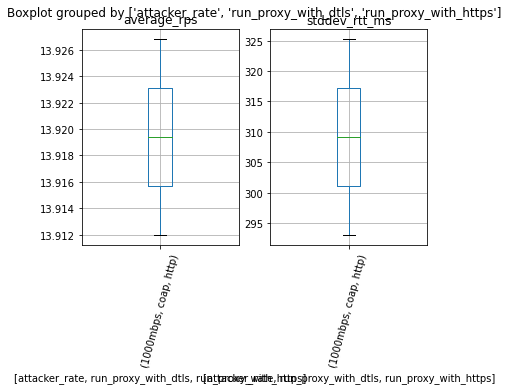

In [34]:
df = client_rps_df
param_comparison_scope = ["attacker_rate", "run_proxy_with_dtls", "run_proxy_with_https"]

plot_args = {
  "rot": 75,
  "by": param_comparison_scope,
}

plots = ["average_rps", "stddev_rtt_ms"]
_, axes = plt.subplots(1, len(plots))
for i, p in enumerate(plots):
  df.boxplot(p, ax=axes[i], **plot_args)

plt.show()

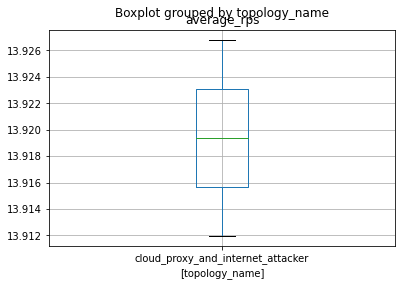

In [35]:
param_comparison_scope = ["topology_name"]

ax = None
ax = df.boxplot("average_rps", by=param_comparison_scope, ax=ax)
plt.show()

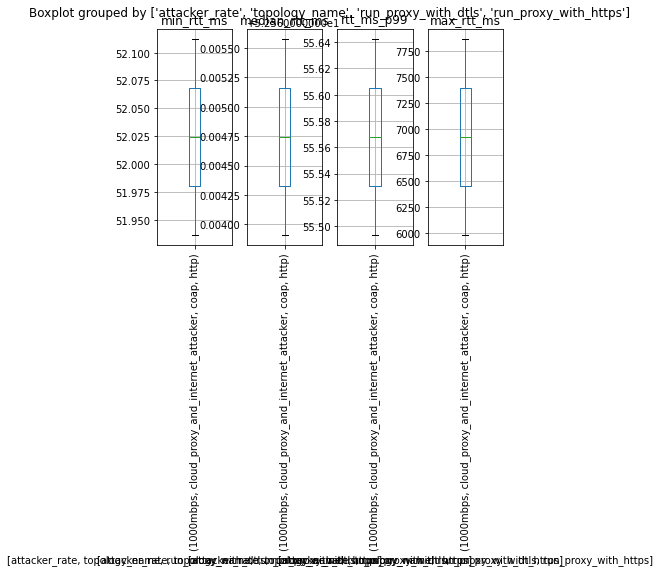

In [36]:
param_comparison_scope = ["attacker_rate", "topology_name", "run_proxy_with_dtls", "run_proxy_with_https"]

plot_args = {
  "by": param_comparison_scope,
  "rot": 90,
}

_, axes = plt.subplots(1, 4)

df.boxplot("min_rtt_ms", ax=axes[0], **plot_args)
df.boxplot("median_rtt_ms", ax=axes[1], **plot_args)
df.boxplot("rtt_ms_p99", ax=axes[2], **plot_args)
df.boxplot("max_rtt_ms", ax=axes[3], **plot_args)

plt.show()